In [1]:
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

### 2. Object Twin (workload 3 students):
In this exercise, we will load a realsense-viewer rosbag recording, then use opencv and pyrender to create a twin of a moving checkerboard.
1. Loading color and depth data:
     * Use pyrealsense2 to read the bagfile and acquire color, depth, aligned depth to color, color camera intrinsics, depth camera intrinsics. (Show the images in a loop using `cv2.imshow`)
     
2. Checkerboard detection and tracking: 
     * The checkerboard has a `6x9` pattern where each square has an edge length of 4 cm.
     * Using opencv we want Find its corners (use `cv2.findChessboardCorners`, and `cv2.cornersSubPix`). then use `cv2.drawChessboardCorners` to overlay the detections on the colored image
     * From the previous step, you will have 2D/3D correspondences for the corners. Use `cv2.solvePnP` to estimate the object to camera translation and rotation vectors.
     * *Extra:* Use opencv drawing utils and perspective projection function to draw a 3D axis, and a cropping mask for the board. Useful functions here could be `cv2.line,cv2.projectPoints,cv2.fillPoly`.
3. Modeling the checkerboard in pyrender:
    * Using pyrender create a scene with camera and a `Box` mesh corresponding to the checkerboard.
    * Notes:
      1. You will need to scale the box and shift its center to match the checkerboard 3d coordinate system in opencv
      2. To convert from opencv camera to pyrender camera in you system you may need to rotate your objects by 90 degees around the X-axis (depending on your implementation) 
4. Visualization and Comparasion:
    * In the loop, update the mesh pose with the updated pose of the checkerboard
    * Compare the rendered depth value to the actual algined_depth values we got from realsense.
    * Optional: Report the Root Mean Squared Error RMSE between the rendered depth, and the actual depth within the detected area
a sample visualization could be seen in the figuire below
![image](assets/hw-1-2-example.png)

In [18]:
# Path to your .bag file
bag_file = "/workspace/NS1/01-Realsense/Homework/HW1-2-data/20220405_220626.bag"

# Create a pipeline
pipeline = rs.pipeline()

# Create a config object and configure it to use your recorded file
config = rs.config()
rs.config.enable_device_from_file(config, bag_file, repeat_playback=False)


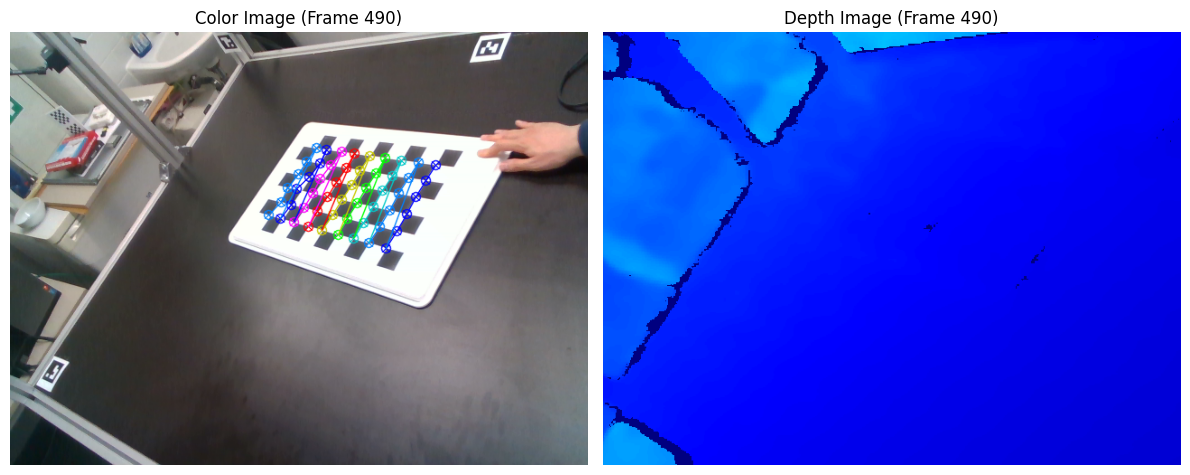

Processed 500 frames, checkerboard detection attempted on each.
Done!


In [20]:
# Start pipeline with the config (no need to enable streams - they're auto-detected from bag file)
profile = pipeline.start(config)

# Alignment (if you want aligned color and depth)
align = rs.align(rs.stream.color)
try:
    frame_count = 0
    max_frames = 500  # Limit frames to avoid too much output

    # Checkerboard settings
    checkerboard_size = (6, 9)  # 6 rows, 9 columns (internal corners, not squares)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Create figure for displaying images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    while frame_count < max_frames:
        # Wait for frames
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)
        color_frame = aligned_frames.get_color_frame()
        depth_frame = aligned_frames.get_depth_frame()

        if not color_frame or not depth_frame:
            print("End of bag file or no frames available")
            break

        # Convert images to numpy arrays
        color_image = np.asanyarray(color_frame.get_data())
        depth_image = np.asanyarray(depth_frame.get_data())

        # Convert color to grayscale for checkerboard detection
        gray = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

        # Try to find the chessboard corners
        found, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

        # Prepare the image for display (for matplotlib: needs RGBA)
        color_for_draw = color_image.copy()
        if found:
            # Refine corner locations
            corners2 = cv2.cornerSubPix(
                gray, corners, (11, 11), (-1, -1), criteria
            )
            # Draw the corners on the color image
            cv2.drawChessboardCorners(color_for_draw, checkerboard_size, corners2, found)

        # Normalize depth image for better visualization
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        # Display every 10th frame to avoid too much output
        if frame_count % 10 == 0:
            clear_output(wait=True)

            # Convert BGR to RGBA for matplotlib (cv2 uses RGB, so treat as such)
            color_rgba = cv2.cvtColor(color_for_draw, cv2.COLOR_RGB2RGBA)
            depth_rgb = cv2.cvtColor(depth_colormap, cv2.COLOR_BGR2RGB)

            # Display images
            ax1.clear()
            ax1.imshow(color_rgba)
            ax1.set_title(f'Color Image (Frame {frame_count})')
            ax1.axis('off')

            ax2.clear()
            ax2.imshow(depth_rgb)
            ax2.set_title(f'Depth Image (Frame {frame_count})')
            ax2.axis('off')

            plt.tight_layout()
            display(fig)

        frame_count += 1

    print(f"Processed {frame_count} frames, checkerboard detection attempted on each.")

except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
finally:
    pipeline.stop()
    plt.close()
    print("Done!")